# 01a_ Introduction to atmospheric transparency

- author Sylvie Dagoret-Campagne
- creation date : 2023/02/21
- last verification : 2023/03/05

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import the fit tools

- import rubin sim

In [3]:
from importlib.metadata import version
the_ver = version('atmosphtransmemullsst')
print(f"Version of atmosphtransmemullsst : {the_ver}")

Version of atmosphtransmemullsst : 0.0.1


In [4]:
import atmosphtransmemullsst
from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

emul = SimpleAtmEmulator(os.path.join(atmosphtransmemullsst.__path__[0],'../data/simplegrid'))

SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [5]:
WL = emul.GetWL()

In [6]:
import sys
sys.path.append('../lib')
import libAtmosphericFit

libAtmosphericFit.py :: Use atmosphtransmemullsst.__path__[0],'../data/simplegrid as the path to data
libAtmosphericFit.py :: data_path = /Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid
SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [7]:
from rubin_sim.phot_utils import Bandpass, Sed
from rubin_sim.data import get_data_dir

In [8]:
Bandpass?

Init signature:
Bandpass(
    wavelen=None,
    sb=None,
    wavelen_min=None,
    wavelen_max=None,
    wavelen_step=None,
)
Docstring:      Hold and use telescope throughput curves.
Init docstring:
Initialize bandpass object, with option to pass wavelen/sb arrays in directly.

Also can specify wavelength grid min/max/step or use default - sb and wavelen will
be resampled to this grid. If wavelen/sb are given, these will be set, but phi
will be set to None.
Otherwise all set to None and user should call read_throughput, read_throughputList,
or imsim_bandpass to populate bandpass data.
File:           ~/MacOSX/GitHub/LSST/rubin_sim/rubin_sim/phot_utils/bandpass.py
Type:           type
Subclasses:     

In [9]:
path_rubin_sim_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline")
atm_std_filename = "atmos_std.dat"

## Configuration

In [10]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

In [11]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

## Initialisation

FILTERWL: precalculated array containing center, boundaries and width of each filter.

    index 0 : minimum wavelength of filter border
    index 1 : minimum wavelength of filter border
    index 2 : center wavelength of filter
    index 3 : filter width

In [12]:
FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

### Standard filters

We load the standard filters 'effective'for Rubin LSST from `rubin_sim` package. Note those filters includes not only the instrumental filters but also atmosphere transmission.

The atmosphere transmission in those effective filters is called the standard atmosphere. The standard atmosphere is defined as the most representative the atmospheric transmission at the reference airmass $am$ being the most probable airmass calculated form the observation cadence..

By convention the reference airmass $am = 1.2$.

We are going to compute the different transmission filters.
Those will be saved in the following pandas dataframe.

In [13]:
df_std=pd.DataFrame()  # dataframe to hold all transmissions
df_std["wl"] = WL      # wavelength array saved in the dataframe

### Effective transmission

The total transmission or throuput of the instrument is the product of the atmospheric transmission $S^{std}_{atm}(\lambda)$ by the telescope transmission $S_{b\; inst}^{std}(\lambda)$ in the band $b$:

$$
S_b^{std}(\lambda) = S^{std}_{atm}(\lambda) \times S_{b\; inst}^{std}(\lambda)
$$


Both have a wavelength dependence. In practice both the instrument transmission and the atmospheric transmission varies with time.
Supposing we know for each LSST telescope what are the effective transmissions, 

$$
S_b^{obs}(\lambda) = S^{obs}_{atm}(\lambda) \times S_{b \; inst}^{obs}(\lambda)
$$

in anycase the Flux and magnitude of the object in the catalog must be calculated as if the transmission function of the instrument was really $S_b^{std}(\lambda)$.

The goal of the DESC Photometric Correction technical working group is to participate in :
- the time dependent measurement of $S^{obs}_{atm}(\lambda)$ and $S_{b\; inst}^{obs}(\lambda)$,
- determining the optimal standard transmissions $S^{std}_{atm}(\lambda)$ and $S_{b\; inst}^{std}(\lambda)$, minimizing biases in magnitudes.
- apply so-called corrections to magnitude determination before flux coaddition, due to the time variation of the transmission when possible,
- Evaluate the residuals sytematics of those corrections.


In principle, those corrections should take place in DM pipeline before the source catalog is released.
However in some cases of trancient sciences like that of Supernovae, it may be possible to apply some corrections after the release of the catalog.

Text(0.5, 1.0, 'Instrument + atmosphere transmission')

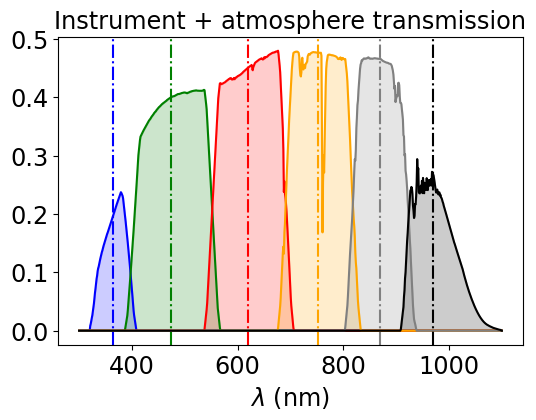

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
    # filter throughput including atm
    throughput_x_atm = ff(WL)
    # filter throughput without atm
    #throughput2=throughput1/atm_std
    
    tag1="tot_"+filter_tagnames[index] # tagname meaning the total transmission
    
    df_std[tag1] = throughput_x_atm # save the throughput for later use
    
    axs.plot(WL,throughput_x_atm,color=filter_color[index]) 
    axs.fill_between(WL,throughput_x_atm,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument + atmosphere transmission")

We can calculate the instrumental filter by dividing the
effective filter by the standard atmospheric atmosphere transmission

### Standard atmosphere

In [15]:
fullfilename=os.path.join(path_rubin_sim_throughput,atm_std_filename)
arr= np.loadtxt(fullfilename)
    
# interpolate  filter transmission
ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
# filter throughput including atm
transm_atm_std =atm = ff(WL)

Text(0.5, 1.0, 'Standard atmosphere transmission')

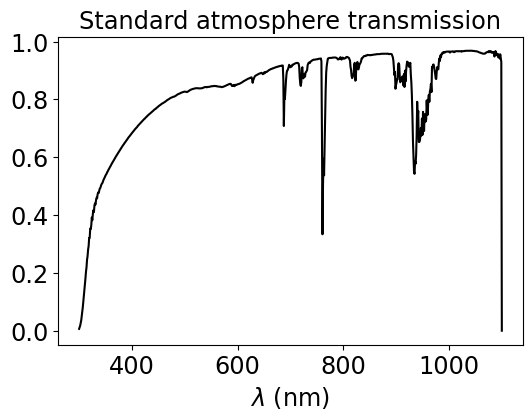

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(WL,transm_atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

Save the standard atmosphere in the pandas dataframe for later use

In [17]:
df_std["atm"] = transm_atm_std

### Instrumental throughput

By dividing the effective filter transmission by the standard atmospheric transmission, one get the instrumental transmission. It consists in the product of the following transmission or throughput :
- physical filters transmission $(u,g,r,i,z,y)$,
- 3 mirrors relfexion coefficient,
- optics transmission,
- CCD quantum efficiency.


Text(0.5, 1.0, 'Instrument transmission')

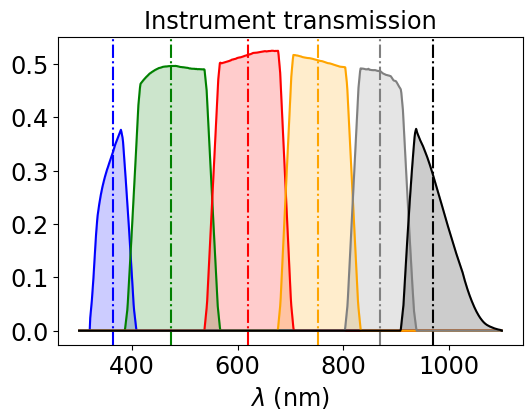

In [18]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    
    
    # filter throughput including atm extracted from pandas dataframe
    tag1="tot_"+filter_tagnames[index]
    throughput_x_atm = df_std[tag1].values
    # filter throughput without atm
    #throughput2=throughput1/atm_std
    throughput = throughput_x_atm/transm_atm_std 
    tag2 = "inst_"+filter_tagnames[index] # tagname meaning the instrumental transmission
    
    df_std[tag2] = throughput# save the throughput for later use in dataframe
   
    axs.plot(WL,throughput,color=filter_color[index]) 
    axs.fill_between(WL,throughput,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

Note at this point we have saved the transmissions in the folowing dataframe

In [19]:
df_std.head()

,wl,tot_u,tot_g,tot_r,tot_i,tot_z,tot_y,atm,inst_u,inst_g,inst_r,inst_i,inst_z,inst_y
0,300.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.006410,0.0,0.0,0.0,0.0,0.0,0.0
1,301.001252,0.0,0.0,0.0,0.0,0.0,0.0,0.011915,0.0,0.0,0.0,0.0,0.0,0.0
2,302.002503,0.0,0.0,0.0,0.0,0.0,0.0,0.017428,0.0,0.0,0.0,0.0,0.0,0.0
3,303.003755,0.0,0.0,0.0,0.0,0.0,0.0,0.026622,0.0,0.0,0.0,0.0,0.0,0.0
4,304.005006,0.0,0.0,0.0,0.0,0.0,0.0,0.035820,0.0,0.0,0.0,0.0,0.0,0.0


# Question 1 : Estimate the parameters of the standard atmosphere in `rubin_sim`

## Example of calling the atmospheric emulator

In [20]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
taus= [0.04]# Vertical Aerosol depth (VAOD) 
betas = [-1]# Aerosol Angstrom exponent

In [21]:
transm_atm_emul = emul.GetAllTransparencies(WL,am0,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)

In [22]:
my_fitatm_std = True

#### If you don't find the solution, call the fitter
- uncomment the following lines

In [23]:
from libAtmosphericFit import FitAtmosphericParams
params0 = [am0,pwv0,oz0, taus[0], betas[0]]
my_fitter = FitAtmosphericParams()
myres,myfit = my_fitter.fit_transmampwvozaer(params0,WL,transm_atm_std)
my_fitatm_std = my_fitter.pred_transmampwvozaer(myfit['popt'],WL)
print("airmass, pwv, ozone, aer : vaod, beta",myfit['popt'])

Init FitAtmosphericParams
airmass, pwv, ozone, aer : vaod, beta [ 1.27714184e+00  4.45620341e+00  3.10122246e+02  3.25068903e-02
 -3.80763466e-01]


## Compare the emulator and the official standard transmission

Text(0.5, 0, '$\\lambda$ (nm)')

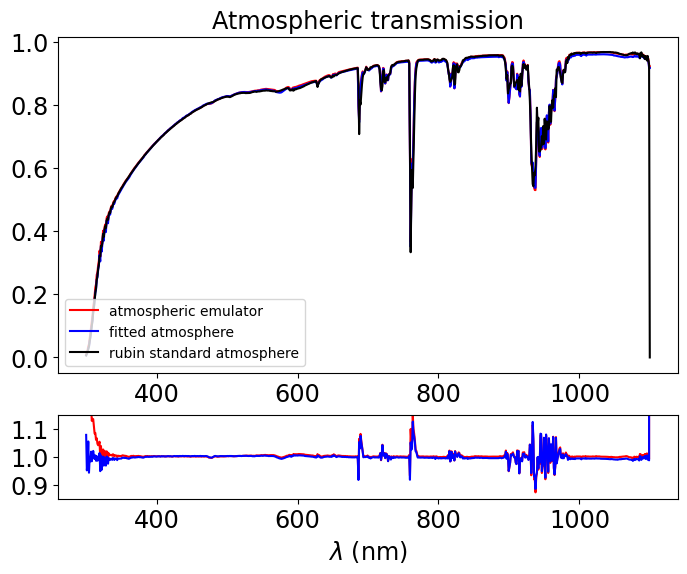

In [24]:
fig = plt.figure(figsize=(8,6))

gs = GridSpec(2, 1,  height_ratios=[4, 1], figure=fig)
axs1 = fig.add_subplot(gs[0,0])

axs1.plot(WL,transm_atm_emul,'r-',label = 'atmospheric emulator')
if my_fitatm_std is not None:
    axs1.plot(WL,my_fitatm_std,'b-',label = 'fitted atmosphere')
axs1.plot(WL,transm_atm_std,'k-', label = "rubin standard atmosphere")
axs1.legend(loc="lower left")
axs1.set_title("Atmospheric transmission")
main_ax =axs1

axs2 = fig.add_subplot(gs[1,0],sharex=main_ax)
axs2.plot(WL,transm_atm_emul/transm_atm_std,'r-',label = 'emulator/rubin-std')
if my_fitatm_std is not None:
    axs2.plot(WL,my_fitatm_std/transm_atm_std,'b-',label = 'emulator/rubin-std')
axs2.set_ylim(0.85,1.15)
axs2.set_xlabel("$\\lambda$ (nm)")

### Commment on the atmosphere fit of the Rubin standard atmosphere
It looks the libradtran model of Oxygen (in the emulator) underestimation O2 absorption modeled in the Rubin standard atmosphere (probably extracted from a Modtran model).
Thus the fitter tend to overestimate airmass to compensable for a low O2 absorption.

For this tutorial we stick to the standard 
- airmass = 1.2
- pwv = 4
- ozone = 300.
- aerosol vaod = 0.04
- betas = -1


Thus we recompute the standard atmosphere:

In [25]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
taus= [0.04]# Vertical Aerosol depth (VAOD) 
betas = [-1]# Aerosol Angstrom exponent

Text(0.5, 1.0, 'total transmission (and instrument)')

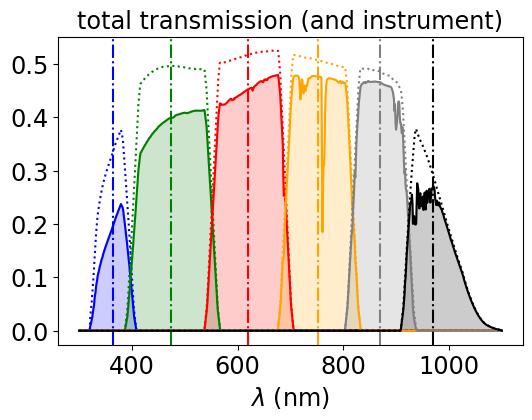

In [26]:
# Define the standard atmosphere as the one given by the emulator
transm_atm_emul = emul.GetAllTransparencies(WL,am0,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
df_std["atm"] = transm_atm_emul
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index in range(NFILT):
    
    # get instrumental throughput
    tag2 = "inst_"+filter_tagnames[index] # tagname meaning the instrumental transmission 
    throughput = df_std[tag2] # save the throughput for later use in dataframe
    
    tag1="tot_"+filter_tagnames[index]
    
    # filter throughput including atm extracted from pandas dataframe
    tag1="tot_"+filter_tagnames[index]
    throughput_x_atm = df_std[tag2].values * df_std["atm"].values
    df_std[tag1] = throughput_x_atm
    
    axs.plot(WL,throughput,':',color=filter_color[index])
    
    axs.plot(WL,throughput_x_atm,color=filter_color[index]) 
    axs.fill_between(WL,throughput_x_atm,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("total transmission (and instrument)")

Because we want to handle atmospheric transmissions with the emulator, whe overwrite the standard transmission in the dataframe.

In [27]:
# loop on filter
for index in range(NFILT):
    
    tag2 ="inst_"+filter_tagnames[index]
    throughput = df_std[tag2].values
    
    df_std["atm"] = transm_atm_emul
    
    tag1="tot_"+filter_tagnames[index]
    throughput_x_atm = throughput * transm_atm_emul
    
    df_std[tag1] = throughput_x_atm
        

## Impact of atmospheric transmission variation on magnitude accuracy

### Choose an object , thus its SED

`rubin_sim`provide a small set of SEDs for different types of objects.
This small library of SEDs should be installed in 
     ~/rubin_sim_data/photometry_sample

If you don't have it, it is possible to download it from this link:

- https://github.com/rhiannonlynne/photometry_sample

In [28]:
!ls ~/rubin_sim_data/photometry_sample

LICENSE         galaxies        photoZ_outliers quasar          stars
README.md       mag_info        plots           sn              white_dwarf


In [29]:
!ls ~/rubin_sim_data/photometry_sample/stars

km10_4500.fits_g45 km10_6000.fits_g45 km10_7250.fits_g45
km10_5250.fits_g45 km10_6500.fits_g45 m3.0Full.dat


Below we read the whole library from files in different folders, to book in a dataframe all the available objects type and objects.

In [30]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [31]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
    
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [32]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Sdm_template_norm0,galaxies
Ell2_template_norm,galaxies
quasar,quasar
km10_5250.fits_g45,stars
km10_4500.fits_g45,stars
km10_6000.fits_g45,stars
km10_7250.fits_g45,stars
km10_6500.fits_g45,stars


### Pickup one SED

In [33]:
sed_name = 'km10_5250.fits_g45'

In [34]:
# Redshift the quasar. Note repeat calls to this cell will stack, increasing the redshift multiple times.
#z=1.5
#seds['quasar'].redshiftSED(z)

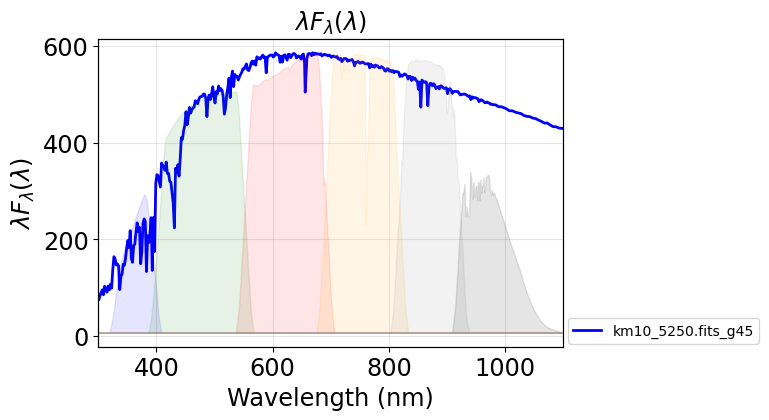

In [35]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(seds[sed_name].wavelen, seds[sed_name].flambda * seds[sed_name].wavelen,"b-",label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("$\lambda F_\lambda(\lambda)$")
ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

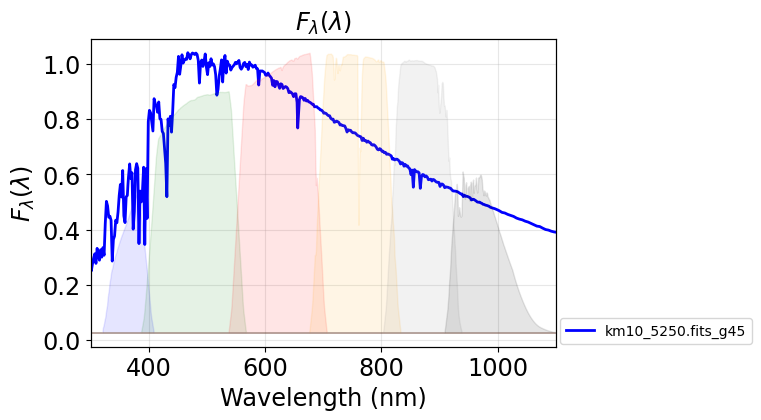

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(seds[sed_name].wavelen, seds[sed_name].flambda,"b-",label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\lambda(\lambda)$")
ax.set_title("$F_\lambda (\lambda)$")
ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

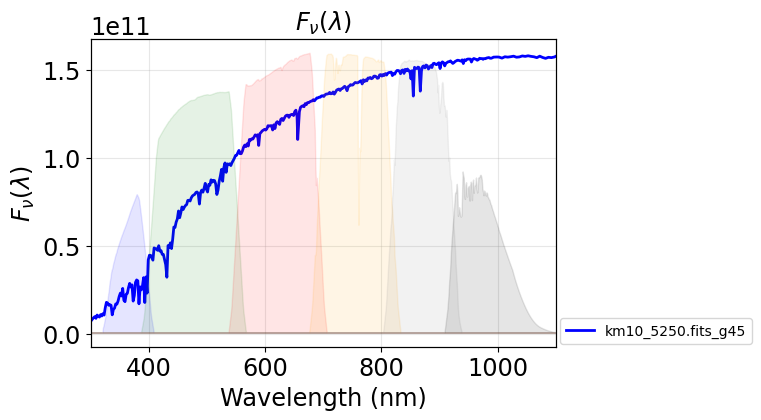

In [37]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(6,4))

wavel,fnu = seds[sed_name].get_sed_fnu()
ax.plot(wavel, fnu,"b-",label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

### Create rubin bandpasses

- we use here the standard passband

In [38]:
lsst_std = {}
for index,f in enumerate(filter_tagnames) :
    
    tag = "tot_"+filter_tagnames[index]
    lsst_std[f] = Bandpass(wavelen = WL , sb= df_std[tag].values )
    

However, let's suppose we had a star which had a spectrum this, but was further away. Say we know that it should have an AB magnitude of r=20.

We can scale the above SED to have the appropriate magnitude in r band, and then calculate the resulting AB magnitudes in the other bandpasses, using the `calcFluxNorm` and `multiplyFluxNorm` methods on Sed.

### Magnitude calculation

In [39]:
# Scale spectrum and recalculate magnitudes.

r = 20.0

flux_norm = seds[sed_name].calc_flux_norm(r, lsst_std['r'])

seds[sed_name].multiply_flux_norm(flux_norm)

In [40]:
flux_norm = seds[sed_name].setup_phi_array

In [41]:
mags_std = {}
for index,f in enumerate(filter_tagnames) :
    mags_std[f] = seds[sed_name].calc_mag(lsst_std[f])
    
pd.DataFrame(mags_std, index=[sed_name]).T

,km10_5250.fits_g45
u,21.766850
g,20.541601
r,20.000000
i,19.812578
z,19.745146
y,19.705321


### Normalized total response

The normalized total response in a band $b$ is defined as: 

$$
\phi^{obs}_b(\lambda) = \frac{S_b^{obs}(\lambda) \frac{1}{\lambda}}{\int S_b^{obs}(\lambda) \frac{d \lambda}{\lambda}}
$$

Because the transmission is unitless, the normalized response has a unit of the inverse of a wavelength unit (for example $nm^{-1}$)

### The AB flux of a source

In flux calibration we refer to the flux of an object relative to a virtual flat source SED ib $F_\nu$ in all wavelength range which flux
is $F_0^{AB}=3631$ Jy ($1 Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}$).

Thus in AB calibration, we use the SED $F_\nu$ whereas in other optical astronomical fields, we mostly use $F_\lambda$.

For source with SED $F_\lambda (\lambda)$,

$$
F_{\nu}(\lambda) = F_\lambda(\lambda) \left| \frac{d\lambda}{d\nu} \right| =  \frac{\lambda^2}{hc}  F_\lambda(\lambda)
$$


or

$$
\nu F_\nu(\lambda) = \lambda F_\lambda(\lambda)
$$

The flux of the source in the AB unit must reported above the atmosphere 
$$
F_{b}^{AB} = \frac{1}{F_{0}^{AB}} \int F_\nu(\lambda) \phi_{b} (\lambda) d\lambda
$$


Thus any observation of a source in the sky provides almost the same AB flux in a similar difference due to the exact shape of $\phi_b^{obs}$ in the band $b$.

For a ground observatory telescope like Rubin-LSST, $\phi_b^{obs}$ varies in time due to instrument and atmosphere variations and airmass.

So a standard transmission $\phi_b^{std}$ must be chosen as the average or most probable transmission and  $F_{b}^{AB}$  has to be corrected for variations
in $\phi_b^{obs}$.

Thus each visit exposure, those variations must be evaluated by calculation or calibration.


####  Calculation $\phi_b^{std}$

For the standard transmission in LSST, `rubin_sim` provides the function $\phi_b$ (which can be calculated easily outside `rubin_sim`): 

In [42]:
phiArray_std, wavelenstep = seds[sed_name].setup_phi_array([lsst_std[f] for f in filter_tagnames])

Text(0.5, 1.0, 'Normalised filter total response $\\phi_b(\\lambda)$')

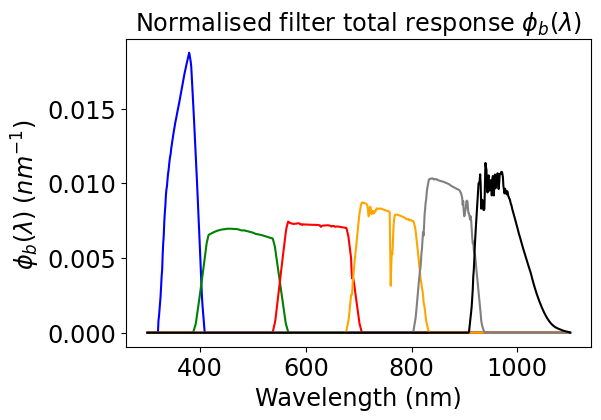

In [43]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
for index,f in enumerate(filter_tagnames):
    ax.plot(WL,phiArray_std[index,:],'-',color=filter_color[index],label = f)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b(\lambda)$")

### Check the integral if $\phi_\nu(\lambda)$ is unitary

In [44]:
for index,f in enumerate(filter_tagnames):
    I = np.trapz(phiArray_std[index,:],WL)
    print(f,I)

u 1.0000000000002816
g 1.0000000000002816
r 1.0000000000002813
i 1.0000000000002813
z 1.0000000000002816
y 1.0000000000002816


# Usefull Integrals definitions


$$
\mathbb{I}_{b\;0}^{std} = \int S_b^{std}(\lambda) \frac{d\lambda}{\lambda}
$$

and

$$
\mathbb{I}_{b\;1}^{std} = \int (\lambda-\lambda_b)\phi_{b}^{std}(\lambda) d\lambda
$$

In [45]:
def fII0(wl,s):
    return np.trapz(s/wl,wl)

In [46]:
def fII1(wl,phi,wlb):
    return np.trapz(phi*(wl-wlb),wl )

In [47]:
# Integral in a dictionnary indexed by filter , one per band
all_II0_std = {}
all_II1_std = {}
for index,f in enumerate(filter_tagnames):
    
    the_II0 = fII0(lsst_std[f].wavelen,lsst_std[f].sb)
    all_II0_std[f] = the_II0
    the_II1 = fII1(WL,phiArray_std[index,:],FILTERWL[index,2])
    all_II1_std[f] = the_II1

In [48]:
all_II0_std

{'u': 0.03342770599423287,
 'g': 0.12212425559041512,
 'r': 0.10116769025345873,
 'i': 0.07750051623903759,
 'z': 0.0537568300296164,
 'y': 0.0258921899817615}

In [49]:
all_II1_std

{'u': 2.347654004910687,
 'g': 2.54825766673013,
 'r': 0.9752678715594711,
 'i': 0.2935876890008666,
 'z': -0.5067283944837335,
 'y': 3.5675077501337142}

In [50]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
taus= [0.04]# Vertical Aerosol depth (VAOD) 
betas = [-1]# Aerosol Angstrom exponent

### Vary airmass and compute $S_b^{obs}$ and $\phi_b^{obs}$

In [51]:
all_am = np.arange(1,2.5,0.2)
NAM = len(all_am)

In [52]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NAM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NAM), alpha=1)

### Calculation of $S_b^{obs}$, $\phi_b^{obs}$ $\mathbb{I}_0^{obs}$, $\mathbb{I}_1^{obs}$

In [53]:
all_bandpass_nonstd_am = []  # bandbass S_b^obs
all_phiArray_nonstd_am = []  # normalized response phi_bôbs
all_II0_nonstd_am = []
all_II1_nonstd_am = []


# loop on airmass
for index_am,am in enumerate(all_am):
    # atmosphere
    transm_atm_emul_nonstd = emul.GetAllTransparencies(WL,am,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
    
    # loop on filters
    lsst_nonstd_am = {} # passband at am
    all_II0_nonstd = {} # II0 dict at am
    all_II1_nonstd = {} # II1 dict at am
    
    # step 1 : calculate passband and II0  
    for index,f in enumerate(filter_tagnames) :
        # instrum thr
        tag ="inst_"+filter_tagnames[index]
        throughput = df_std[tag].values
        # total thr
        total_throuthput_nonstd_am = transm_atm_emul_nonstd * throughput
    
        f = filter_tagnames[index]
        lsst_nonstd_am[f] = Bandpass(wavelen = WL , sb= total_throuthput_nonstd_am )
        the_II0 = fII0(lsst_nonstd_am[f].wavelen,lsst_nonstd_am[f].sb)
        all_II0_nonstd[f] = the_II0    
    all_bandpass_nonstd_am.append(lsst_nonstd_am)
    
    # Step 2 : calculate Phi and II1
    phiArray_nonstd, wavelenstep = seds[sed_name].setup_phi_array([lsst_nonstd_am[f] for f in filter_tagnames])
    
    for index,f in enumerate(filter_tagnames) :
        the_II1 = fII1(WL,phiArray_nonstd[index,:],FILTERWL[index,2])
        all_II1_nonstd[f] = the_II1
    
    all_phiArray_nonstd_am.append(phiArray_nonstd)
    all_II0_nonstd_am.append(all_II0_nonstd)
    all_II1_nonstd_am.append(all_II1_nonstd)

### Plot $S_b^{obs}$, $\phi_b^{obs}$ $\mathbb{I}_0^{obs}$, $\mathbb{I}_1^{obs}$

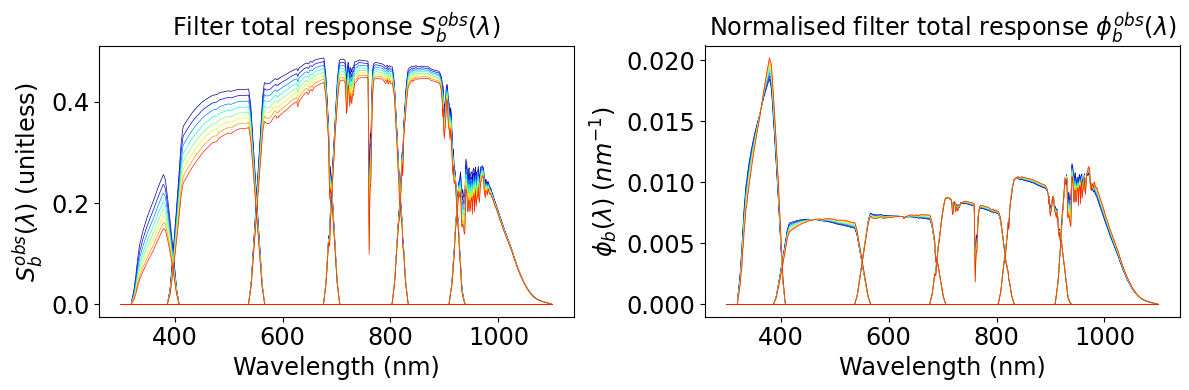

In [54]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)
# loop on airmass
for index_am,am in enumerate(all_am):  
    the_all_bandpass_nonstd_am = all_bandpass_nonstd_am[index_am] 
    for index,f in enumerate(filter_tagnames) :
        the_lsst_nonstd_am_infilter = the_all_bandpass_nonstd_am[f]
        the_wl= the_lsst_nonstd_am_infilter.wavelen
        the_sb = the_lsst_nonstd_am_infilter.sb
        ax.plot(the_wl ,the_sb,'-',color=all_colors[index_am],label = f,lw=0.5)
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$S_b^{obs}(\lambda)$ (unitless) ")
ax.set_title("Filter total response $S_b^{obs}(\lambda)$")

# Figure 2
ax=fig.add_subplot(1,2,2)
# loop on airmass
for index_am,am in enumerate(all_am):  
    the_all_phiArray_nonstd_am = all_phiArray_nonstd_am[index_am] 
    
    for index,f in enumerate(filter_tagnames) :
        
        the_phiArray_nonstd = the_all_phiArray_nonstd_am[index]
        ax.plot(WL,the_phiArray_nonstd,'-',color=all_colors[index_am],lw=0.5)    
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b^{obs}(\lambda)$")

plt.tight_layout()
plt.show()

Whereas in the $S_b^{obs}$ curves one see airmass depth extinction, the normalized response $\phi_b^{obs}$ exibit only color-shape distorsion.

We can check this by computing the following magnitude corrections quantities:
- SED-color independent correction term $\Delta m_1 = -2.5\log_{10}\left( \frac{\mathbb{I}_{b\;0}^{obs}}{\mathbb{I}_{b\;0}^{std}}\right)$ vs airmass,

- SED-color dependent correction term $\Delta m_2 = \left( \mathbb{I}_{b\;1}^{std} - \mathbb{I}_{b\;1}^{obs} \right)$ vs airmass,

### Plot of  $\mathbb{I}_0^{obs}$, $\mathbb{I}_1^{obs}$

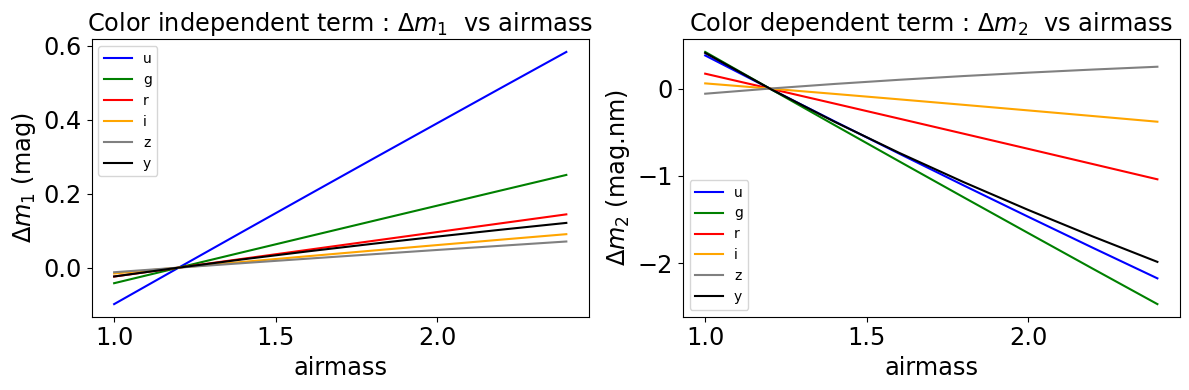

In [55]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NAM)
for index,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II0_ratio = all_II0_nonstd_am[index_am][f]/all_II0_std[f]
        Y[index_am] = -2.5*np.log10(the_II0_ratio)
    ax.plot(all_am,Y,'-',color=filter_color[index],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs airmass')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NAM)
for index,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II1_sub = all_II1_std[f] - all_II1_nonstd_am[index_am][f]
        Y[index_am] = the_II1_sub
    ax.plot(all_am,Y,'-',color=filter_color[index],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs airmass')
ax.legend()
plt.tight_layout()
plt.show()

### Vary PWV at standard airmass

In [56]:
all_pwv = np.arange(0,10,1.)
NPWV = len(all_pwv)

In [57]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NPWV)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NPWV), alpha=1)

#### Calculation of $S_b^{obs}$, $\phi_b^{obs}$ $\mathbb{I}_0^{obs}$, $\mathbb{I}_1^{obs}$

In [58]:
all_bandpass_nonstd_pwv = []  # bandbass S_b^obs
all_phiArray_nonstd_pwv = []  # normalized response phi_bôbs
all_II0_nonstd_pwv = []
all_II1_nonstd_pwv = []


# loop on pwv
for index_pwv,pwv in enumerate(all_pwv):
    # atmosphere
    transm_atm_emul_nonstd = emul.GetAllTransparencies(WL,am0,pwv,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
    
    # loop on filters
    lsst_nonstd_pwv = {} # passband at pwv
    all_II0_nonstd = {} # II0 dict at pwv
    all_II1_nonstd = {} # II1 dict at pwv
    
    # step 1 : calculate passband and II0  
    for index,f in enumerate(filter_tagnames) :
        # instrum thr
        tag ="inst_"+filter_tagnames[index]
        throughput = df_std[tag].values
        # total thr
        total_throuthput_nonstd_pwv = transm_atm_emul_nonstd * throughput
    
        f = filter_tagnames[index]
        lsst_nonstd_pwv[f] = Bandpass(wavelen = WL , sb= total_throuthput_nonstd_pwv )
        the_II0 = fII0(lsst_nonstd_pwv[f].wavelen,lsst_nonstd_pwv[f].sb)
        all_II0_nonstd[f] = the_II0    
    all_bandpass_nonstd_pwv.append(lsst_nonstd_pwv)
    
    # Step 2 : calculate Phi and II1
    phiArray_nonstd, wavelenstep = seds[sed_name].setup_phi_array([lsst_nonstd_pwv[f] for f in filter_tagnames])
    
    for index,f in enumerate(filter_tagnames) :
        the_II1 = fII1(WL,phiArray_nonstd[index,:],FILTERWL[index,2])
        all_II1_nonstd[f] = the_II1
    
    all_phiArray_nonstd_pwv.append(phiArray_nonstd)
    all_II0_nonstd_pwv.append(all_II0_nonstd)
    all_II1_nonstd_pwv.append(all_II1_nonstd)

### Plot $S_b^{obs}$, $\phi_b^{obs}$ $\mathbb{I}_0^{obs}$, $\mathbb{I}_1^{obs}$

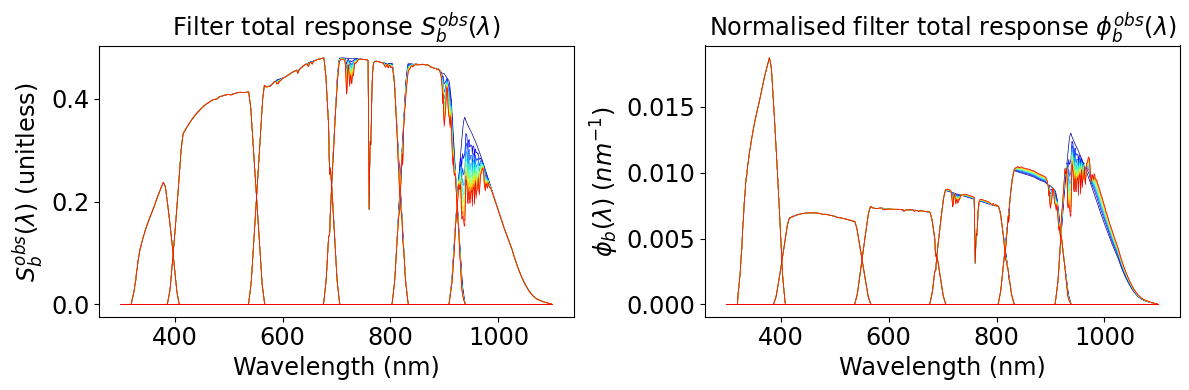

In [59]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)
# loop on airmass
for index_pwv,pwv in enumerate(all_pwv):  
    the_all_bandpass_nonstd_pwv = all_bandpass_nonstd_pwv[index_pwv] 
    for index,f in enumerate(filter_tagnames) :
        the_lsst_nonstd_pwv_infilter = the_all_bandpass_nonstd_pwv[f]
        the_wl= the_lsst_nonstd_pwv_infilter.wavelen
        the_sb = the_lsst_nonstd_pwv_infilter.sb
        ax.plot(the_wl ,the_sb,'-',color=all_colors[index_pwv],label = f,lw=0.5)
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$S_b^{obs}(\lambda)$ (unitless) ")
ax.set_title("Filter total response $S_b^{obs}(\lambda)$")

# Figure 2
ax=fig.add_subplot(1,2,2)
# loop on airmass
for index_pwv,pwv in enumerate(all_pwv):  
    the_all_phiArray_nonstd_pwv = all_phiArray_nonstd_pwv[index_pwv] 
    
    for index,f in enumerate(filter_tagnames) :
        
        the_phiArray_nonstd = the_all_phiArray_nonstd_pwv[index]
        ax.plot(WL,the_phiArray_nonstd,'-',color=all_colors[index_pwv],lw=0.5)    
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b^{obs}(\lambda)$")

plt.tight_layout()
plt.show()

### Plot of  $\mathbb{I}_0^{obs}$, $\mathbb{I}_1^{obs}$

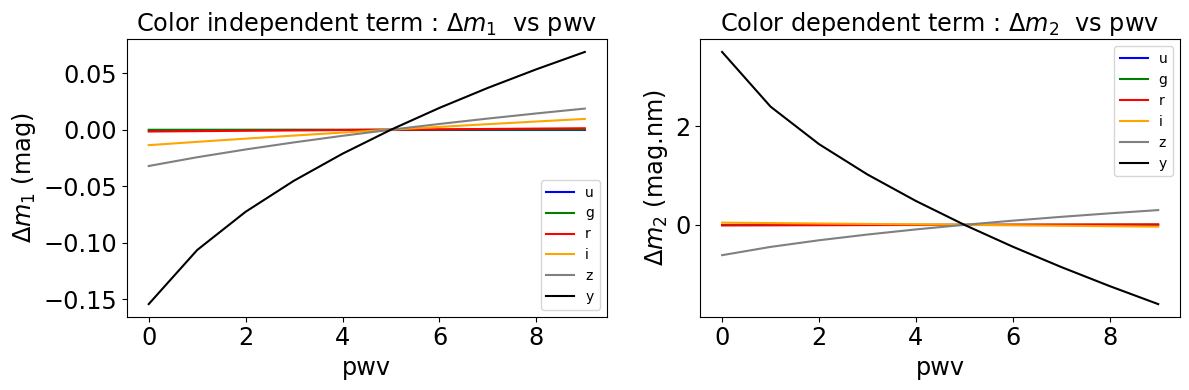

In [60]:
all_II0_ratio = np.zeros((NFILT,NPWV))
all_II1_sub = np.zeros((NFILT,NPWV))

fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NPWV)
# external loop on pwv
for index,f in enumerate(filter_tagnames):
    # internal loop on pwv
    for index_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio = all_II0_nonstd_pwv[index_pwv][f]/all_II0_std[f]
        Y[index_pwv] = -2.5*np.log10(the_II0_ratio)
        all_II0_ratio[index,index_pwv] = Y[index_pwv]
    ax.plot(all_pwv,Y,'-',color=filter_color[index],label=f)
    
    
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs pwv')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NPWV)
for index,f in enumerate(filter_tagnames):
    # loop on pwv
    for index_pwv,pwv in enumerate(all_pwv):
        the_II1_sub = all_II1_std[f] - all_II1_nonstd_pwv[index_pwv][f]
        Y[index_pwv] = the_II1_sub
        all_II1_sub[index,index_pwv] = Y[index_pwv]
    ax.plot(all_pwv,Y,'-',color=filter_color[index],label=f)
   
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs pwv')
ax.legend()
plt.tight_layout()
plt.show()

## What if changing the standard airmass to 2

In [61]:
am0 =2.0    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
taus= [0.04]# Vertical Aerosol depth (VAOD) 
betas = [-1]# Aerosol Angstrom exponent

Text(0.5, 1.0, 'total transmission (and instrument) at airmass = 2.0')

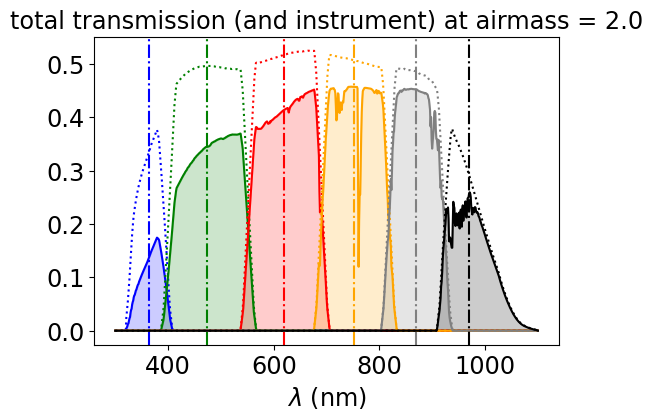

In [62]:
# Define the standard atmosphere as the one given by the emulator
transm_atm_emul = emul.GetAllTransparencies(WL,am0,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
df_std["atm"] = transm_atm_emul
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index in range(NFILT):
    
    # get instrumental throughput
    tag2 = "inst_"+filter_tagnames[index] # tagname meaning the instrumental transmission 
    throughput = df_std[tag2] # save the throughput for later use in dataframe
    
    tag1="tot_"+filter_tagnames[index]
    
    # filter throughput including atm extracted from pandas dataframe
    tag1="tot_"+filter_tagnames[index]
    throughput_x_atm = df_std[tag2].values * df_std["atm"].values
    df_std[tag1] = throughput_x_atm
    
    axs.plot(WL,throughput,':',color=filter_color[index])
    
    axs.plot(WL,throughput_x_atm,color=filter_color[index]) 
    axs.fill_between(WL,throughput_x_atm,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title(f"total transmission (and instrument) at airmass = {am0}")

In [63]:
lsst_std = {}
for index,f in enumerate(filter_tagnames) :
    
    tag = "tot_"+filter_tagnames[index]
    lsst_std[f] = Bandpass(wavelen = WL , sb= df_std[tag].values )

In [64]:
phiArray_std, wavelenstep = seds[sed_name].setup_phi_array([lsst_std[f] for f in filter_tagnames])

Text(0.5, 1.0, 'Normalised filter total response $\\phi_b(\\lambda)$')

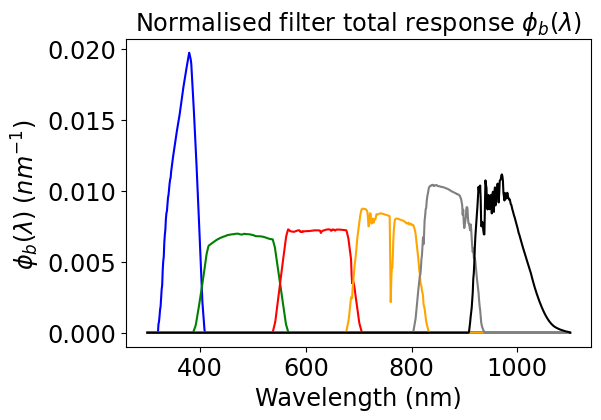

In [65]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
for index,f in enumerate(filter_tagnames):
    ax.plot(WL,phiArray_std[index,:],'-',color=filter_color[index],label = f)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b(\lambda)$")

In [66]:
# Integral in a dictionnary indexed by filter , one per band
all_II0_std = {}
all_II1_std = {}
for index,f in enumerate(filter_tagnames):
    
    the_II0 = fII0(lsst_std[f].wavelen,lsst_std[f].sb)
    all_II0_std[f] = the_II0
    the_II1 = fII1(WL,phiArray_std[index,:],FILTERWL[index,2])
    all_II1_std[f] = the_II1

In [67]:
all_am = np.arange(1,2.5,0.2)
NAM = len(all_am)

In [68]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NAM)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NAM), alpha=1)

In [69]:
all_bandpass_nonstd_am = []  # bandbass S_b^obs
all_phiArray_nonstd_am = []  # normalized response phi_bôbs
all_II0_nonstd_am = []
all_II1_nonstd_am = []


# loop on airmass
for index_am,am in enumerate(all_am):
    # atmosphere
    transm_atm_emul_nonstd = emul.GetAllTransparencies(WL,am,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
    
    # loop on filters
    lsst_nonstd_am = {} # passband at am
    all_II0_nonstd = {} # II0 dict at am
    all_II1_nonstd = {} # II1 dict at am
    
    # step 1 : calculate passband and II0  
    for index,f in enumerate(filter_tagnames) :
        # instrum thr
        tag ="inst_"+filter_tagnames[index]
        throughput = df_std[tag].values
        # total thr
        total_throuthput_nonstd_am = transm_atm_emul_nonstd * throughput
    
        f = filter_tagnames[index]
        lsst_nonstd_am[f] = Bandpass(wavelen = WL , sb= total_throuthput_nonstd_am )
        the_II0 = fII0(lsst_nonstd_am[f].wavelen,lsst_nonstd_am[f].sb)
        all_II0_nonstd[f] = the_II0    
    all_bandpass_nonstd_am.append(lsst_nonstd_am)
    
    # Step 2 : calculate Phi and II1
    phiArray_nonstd, wavelenstep = seds[sed_name].setup_phi_array([lsst_nonstd_am[f] for f in filter_tagnames])
    
    for index,f in enumerate(filter_tagnames) :
        the_II1 = fII1(WL,phiArray_nonstd[index,:],FILTERWL[index,2])
        all_II1_nonstd[f] = the_II1
    
    all_phiArray_nonstd_am.append(phiArray_nonstd)
    all_II0_nonstd_am.append(all_II0_nonstd)
    all_II1_nonstd_am.append(all_II1_nonstd)

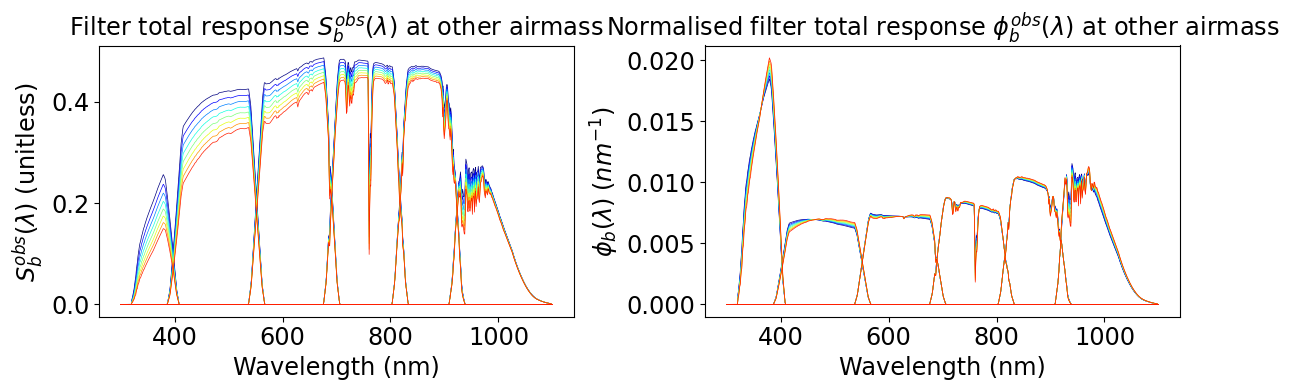

In [70]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)
# loop on airmass
for index_am,am in enumerate(all_am):  
    the_all_bandpass_nonstd_am = all_bandpass_nonstd_am[index_am] 
    for index,f in enumerate(filter_tagnames) :
        the_lsst_nonstd_am_infilter = the_all_bandpass_nonstd_am[f]
        the_wl= the_lsst_nonstd_am_infilter.wavelen
        the_sb = the_lsst_nonstd_am_infilter.sb
        ax.plot(the_wl ,the_sb,'-',color=all_colors[index_am],label = f,lw=0.5)
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$S_b^{obs}(\lambda)$ (unitless) ")
ax.set_title("Filter total response $S_b^{obs}(\lambda)$ at other airmass")

# Figure 2
ax=fig.add_subplot(1,2,2)
# loop on airmass
for index_am,am in enumerate(all_am):  
    the_all_phiArray_nonstd_am = all_phiArray_nonstd_am[index_am] 
    
    for index,f in enumerate(filter_tagnames) :
        
        the_phiArray_nonstd = the_all_phiArray_nonstd_am[index]
        ax.plot(WL,the_phiArray_nonstd,'-',color=all_colors[index_am],lw=0.5)    
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b^{obs}(\lambda)$ at other airmass")

plt.tight_layout()
plt.show()

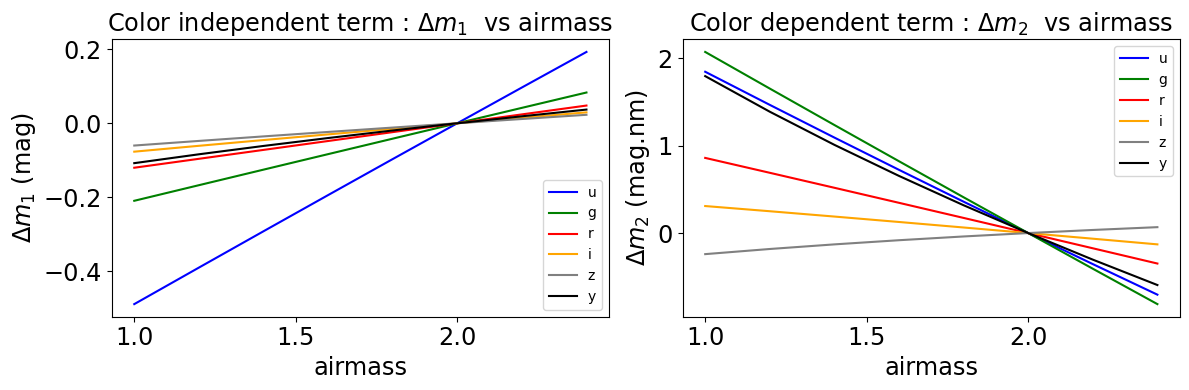

In [71]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NAM)
for index,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II0_ratio = all_II0_nonstd_am[index_am][f]/all_II0_std[f]
        Y[index_am] = -2.5*np.log10(the_II0_ratio)
    ax.plot(all_am,Y,'-',color=filter_color[index],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs airmass')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NAM)
for index,f in enumerate(filter_tagnames):
    # loop on airmass
    for index_am,am in enumerate(all_am):
        the_II1_sub = all_II1_std[f] - all_II1_nonstd_am[index_am][f]
        Y[index_am] = the_II1_sub
    ax.plot(all_am,Y,'-',color=filter_color[index],label=f)
ax.set_xlabel('airmass')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs airmass')
ax.legend()
plt.tight_layout()
plt.show()

In [72]:
all_pwv = np.arange(0,10,1.)
NPWV = len(all_pwv)

In [73]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NPWV)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NPWV), alpha=1)

In [74]:
all_bandpass_nonstd_pwv = []  # bandbass S_b^obs
all_phiArray_nonstd_pwv = []  # normalized response phi_bôbs
all_II0_nonstd_pwv = []
all_II1_nonstd_pwv = []


# loop on pwv
for index_pwv,pwv in enumerate(all_pwv):
    # atmosphere
    transm_atm_emul_nonstd = emul.GetAllTransparencies(WL,am0,pwv,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
    
    # loop on filters
    lsst_nonstd_pwv = {} # passband at pwv
    all_II0_nonstd = {} # II0 dict at pwv
    all_II1_nonstd = {} # II1 dict at pwv
    
    # step 1 : calculate passband and II0  
    for index,f in enumerate(filter_tagnames) :
        # instrum thr
        tag ="inst_"+filter_tagnames[index]
        throughput = df_std[tag].values
        # total thr
        total_throuthput_nonstd_pwv = transm_atm_emul_nonstd * throughput
    
        f = filter_tagnames[index]
        lsst_nonstd_pwv[f] = Bandpass(wavelen = WL , sb= total_throuthput_nonstd_pwv )
        the_II0 = fII0(lsst_nonstd_pwv[f].wavelen,lsst_nonstd_pwv[f].sb)
        all_II0_nonstd[f] = the_II0    
    all_bandpass_nonstd_pwv.append(lsst_nonstd_pwv)
    
    # Step 2 : calculate Phi and II1
    phiArray_nonstd, wavelenstep = seds[sed_name].setup_phi_array([lsst_nonstd_pwv[f] for f in filter_tagnames])
    
    for index,f in enumerate(filter_tagnames) :
        the_II1 = fII1(WL,phiArray_nonstd[index,:],FILTERWL[index,2])
        all_II1_nonstd[f] = the_II1
    
    all_phiArray_nonstd_pwv.append(phiArray_nonstd)
    all_II0_nonstd_pwv.append(all_II0_nonstd)
    all_II1_nonstd_pwv.append(all_II1_nonstd)

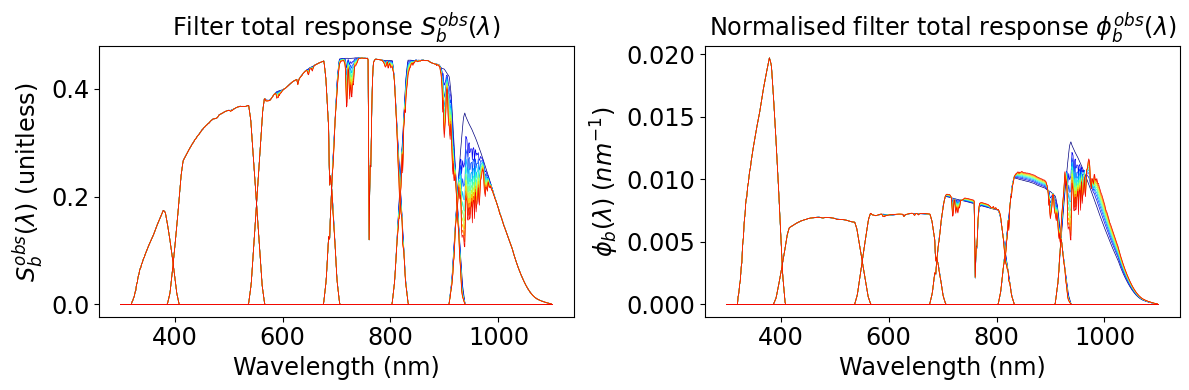

In [75]:
fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)
# loop on airmass
for index_pwv,pwv in enumerate(all_pwv):  
    the_all_bandpass_nonstd_pwv = all_bandpass_nonstd_pwv[index_pwv] 
    for index,f in enumerate(filter_tagnames) :
        the_lsst_nonstd_pwv_infilter = the_all_bandpass_nonstd_pwv[f]
        the_wl= the_lsst_nonstd_pwv_infilter.wavelen
        the_sb = the_lsst_nonstd_pwv_infilter.sb
        ax.plot(the_wl ,the_sb,'-',color=all_colors[index_pwv],label = f,lw=0.5)
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$S_b^{obs}(\lambda)$ (unitless) ")
ax.set_title("Filter total response $S_b^{obs}(\lambda)$")

# Figure 2
ax=fig.add_subplot(1,2,2)
# loop on airmass
for index_pwv,pwv in enumerate(all_pwv):  
    the_all_phiArray_nonstd_pwv = all_phiArray_nonstd_pwv[index_pwv] 
    
    for index,f in enumerate(filter_tagnames) :
        
        the_phiArray_nonstd = the_all_phiArray_nonstd_pwv[index]
        ax.plot(WL,the_phiArray_nonstd,'-',color=all_colors[index_pwv],lw=0.5)    
          
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\phi_b(\lambda)\; (nm^{-1})$ ")
ax.set_title("Normalised filter total response $\phi_b^{obs}(\lambda)$")

plt.tight_layout()
plt.show()

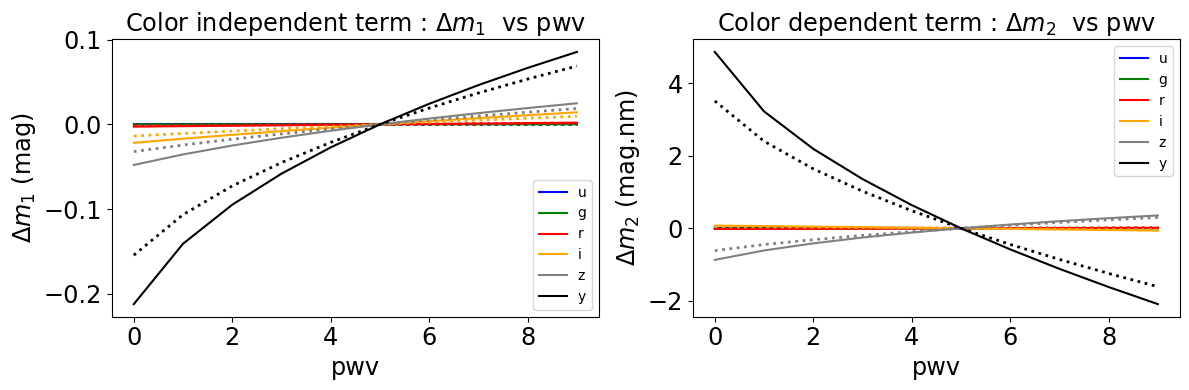

In [76]:
#all_II0_ratio = np.zeros((NFILT,NPWV))
#all_II1_sub = np.zeros((NFILT,NPWV))

fig = plt.figure(figsize=(12,4))

# Figure 1
ax=fig.add_subplot(1,2,1)

Y = np.zeros(NPWV)
for index,f in enumerate(filter_tagnames):
    # loop on pwv
    for index_pwv,pwv in enumerate(all_pwv):
        the_II0_ratio = all_II0_nonstd_pwv[index_pwv][f]/all_II0_std[f]
        Y[index_pwv] = -2.5*np.log10(the_II0_ratio)
    ax.plot(all_pwv,Y,'-',color=filter_color[index],label=f)
    ax.plot(all_pwv,all_II0_ratio[index,:],':',color=filter_color[index],lw=2)
    
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_1$ (mag)')
ax.set_title('Color independent term : $\Delta m_1$  vs pwv')
ax.legend()
          

# Figure 2
ax=fig.add_subplot(1,2,2)
Y = np.zeros(NPWV)
for index,f in enumerate(filter_tagnames):
    # loop on pwv
    for index_pwv,pwv in enumerate(all_pwv):
        the_II1_sub = all_II1_std[f] - all_II1_nonstd_pwv[index_pwv][f]
        Y[index_pwv] = the_II1_sub
    ax.plot(all_pwv,Y,'-',color=filter_color[index],label=f)
    ax.plot(all_pwv,all_II1_sub[index,:],':',color=filter_color[index],lw=2)
ax.set_xlabel('pwv')
ax.set_ylabel('$\Delta m_2$ (mag.nm)')
ax.set_title('Color dependent term : $\Delta m_2$  vs pwv')
ax.legend()
plt.tight_layout()
plt.show()

### Check the distorsion impact for varying observing conditions by changing the following variables:

- airmass in range [1-2.5]
- pwv in range [1,9] mm
- ozone in range [100-600] DU
- aerosols in range [0- 0.1] 


**Step 1 :** View the filter shape distorsions in a plot

**Step 2 :**  Evaluate their impact by calculating independently of the SED (or assuming a Flat SED in $F_\nu$):

$$
\Delta m_b = 2.5 \log_{10} \frac{\int \phi_b^{obs}(\lambda)d\lambda}{\int \phi_b^{std}(\lambda)d\lambda}
$$

** Step 3 :** Evaluate their impact when choosing a particular SED.

- for example choose a blue star SED and a red star SED and vary only the pwv. Compare the ratio in the band $b$ ($y,z,i$):

$$
\Delta m_b = 2.5 \log_{10} \frac{\int F_\nu(\lambda)\phi_b^{obs}(\lambda)d\lambda}{\int F_\nu(\lambda)\phi_b^{std}(\lambda)d\lambda}
$$


# Take Home Message